# Getting started with Deltaflow

This notebook will take you through the creation of a simple Deltaflow program and explain the core concepts along the way.

### Terminology

Dataflow programming is the core concept behind Deltaflow.
We split this paradigm into three parts:

1. **Block definition**.
A _block_ is a contiguous piece of code that can run independent of any other code.
In theory, blocks can be written in any language.
Currently we are using Python as a demonstration language.

2. **Node connectivity**.
Also called the "wiring".
A node is an object that is responsible for running a single block by collecting input
values from, and sending output values to, connected nodes.
We define a collection of connected nodes as an instance of `DeltaGraph`.
You can think of this as a directed graph where edges show the transition of data and
vertices represent operations on said data.

3. **Runtime**.
This is where `DeltaGraph` is executed.
A _runtime_ is responsible for taking `DeltaGraph` and running it on some target
architecture/configuration.
`DeltaGraph` is largely platform agnostic, with dedicated runtimes being written
for each target platform.

4. **Simulator**.
The main distinction from a runtime is that it intrinsically aims to only run `DeltaGraph`
on a _simulated_ hardware, i.e. the entire simulation can run on a single CPU.

## Example code

We start by importing the library.

In [1]:
import deltalanguage as dl

To define a block for use in the Deltaflow system we write a normal Python function and add the `@DeltaBlock` decorator.
This function has several optional arguments.
It is necessary for users to specify the type annotation of arguments and returns in the function signature;
Python does not enforce function/variable type annotations in general, but in Deltaflow specifying them is mandatory.

To learn more about the data types you can see our tutorial on this topic in the main directory.

**Tip**: name is an optional keyword argument for the `DeltaBlock`
decorator that allows us to set the name of nodes created using this block.

In [2]:
@dl.DeltaBlock(name="add")
def add(a: int, b: int) -> int:
    return a + b

This decorated function can still be used as normal when we don't try to put it into a `DeltaGraph`.
This is useful for integrating Deltaflow with existing systems or testing.

In [3]:
x = add(4, 3)

print(x)

assert x == 7

7


To create a node that will represent this block in a `DeltaGraph`,
you can use the provided factories or our `with` syntax.
This example will use the latter.

In [4]:
with dl.DeltaGraph() as graph:
    in_graph_block = add(a=4, b=3)

print(in_graph_block)

node[add_2]:
    ports:
        in:
            a, DInt32
            b, DInt32
    bodies:
        *PyConstBody
            tags: add




We can see that when we call the add function into our `DeltaGraph` context,
it no longer executes normally.
Instead, calling the decorated function has created and returned a node.

This node has also been added to our graph for us, as can be seen by printing the graph.

In [5]:
print(graph)

DeltaGraph[main] {
    node[node_0]:
        ports:
            out:
                output, DInt32 -> add_2.a
        bodies:
            *PyConstBody
                tags: <lambda>

    node[node_1]:
        ports:
            out:
                output, DInt32 -> add_2.b
        bodies:
            *PyConstBody
                tags: <lambda>

    node[add_2]:
        ports:
            in:
                a, DInt32
                b, DInt32
        bodies:
            *PyConstBody
                tags: add

}



Somewhat surprisingly, we see 3 nodes in our graph. This is because the arguments we gave our `add` function also need to become nodes on the `DeltaGraph`. These two created nodes have very simple, automatically constructed, blocks.
The blocks just return the value we want to supply to add.

Knowing to send data from one node to another requires an edge to be created in our `DeltaGraph`.
On the printed format of the graph we can see two edges have been added going into our add node,
one from each of it's created argument nodes.

There is no output for this graph, so let's define another block so we can make a graph where our `add` node can send its result to be printed.

In [6]:
# This is a helper function that will be used to create a node that
# will simply save everything arriving to it.
s = dl.lib.StateSaver(int, verbose=True)

with dl.DeltaGraph() as graph:
    added = add(a=4, b=3)
    s.save_and_exit(added)

print(graph)

DeltaGraph[main] {
    node[node_3]:
        ports:
            out:
                output, DInt32 -> add_5.a
        bodies:
            *PyConstBody
                tags: <lambda>

    node[node_4]:
        ports:
            out:
                output, DInt32 -> add_5.b
        bodies:
            *PyConstBody
                tags: <lambda>

    node[add_5]:
        ports:
            in:
                a, DInt32
                b, DInt32
            out:
                output, DInt32 -> save_and_exit_6.val
        bodies:
            *PyConstBody
                tags: add

    node[save_and_exit_6]:
        ports:
            in:
                val, DInt32
        bodies:
            *PyFuncBody
                tags: save_and_exit

}



This graph now has an additional edge from our `add` node to the `save_and_exit` node.
This is a primitive node from the standard library that receives an input and tell the
runtime or simulator to stop.

We can also create visual representations of our graph using the draw method.
This method uses the [NetworkX](https://networkx.org/) library to draw a graph.

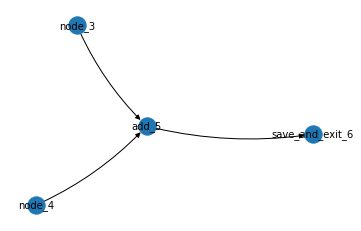

In [7]:
graph.draw(seed=1)

See [draw_networkx](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx) for details on what parameters can be passed to draw.

Note: NetworkX has limited drawing functionality and might not be suitable for visualising more complicated Deltaflow graphs.
To visualise more complex graphs, it is recommended to use `graph.write_gml(path)`, which saves a GraphML file in the location specified by path.
This file can then be imported to more powerful graph visualisation tools such as [Cytoscape](https://cytoscape.org/).
See the [NetworkX](https://networkx.github.io/documentation/stable/reference/drawing.html) documentation for further details.

To run a graph we need a runtime or a simulator, which takes a graph in its constructor.
Here we use the python-based simulator provided with the language that can run graphs using
Python (for CPU) and Migen (for FPGA) nodes.
You will learn about Migen later.

In [8]:
# simply empty the memory before each re-run
s.reset()

rt = dl.DeltaPySimulator(graph)
rt.run()

assert s.saved == [7]

saving 7


During the execution of our graph, once both of the argument nodes have output their data,
the `add` node will call our `add` block using the received data for its arguments.
The `add` node then gets the return value from the `add` block and will pass it on to the `save_and_exit` node.
This node will save its input within `s.saved` and then raise a `DeltaRuntimeExit` exception,
which will cause the runtime to terminate.

Note: Raising a `DeltaRuntimeExit` exception is currently the correct way to terminate
the execution of a graph, which happens inside of `StateSaver`.
Execution termination is managed by the runtime, raising this exception is just a way
to signal to the runtime that execution should stop.